In [1]:
from skimage.io import imread
import matplotlib.pyplot as plt

sudoku_original = imread('resources/sudoku2.JPG')
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(sudoku_original)
plt.show()

<Figure size 1000x1000 with 1 Axes>

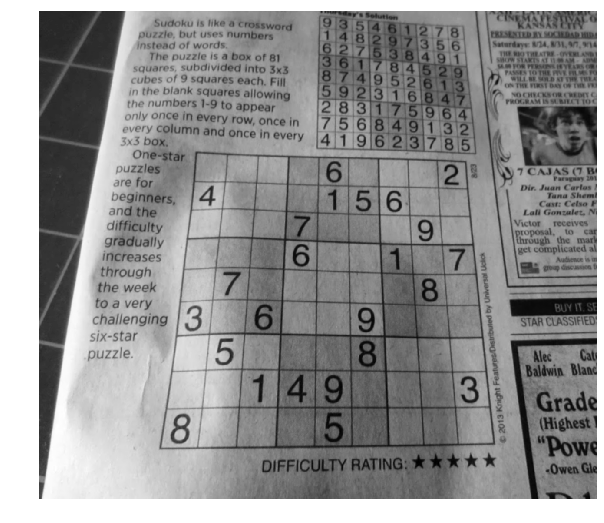

In [2]:
#blur the image
from skimage.filters import gaussian
from skimage.color import rgb2grey
gray_img = rgb2grey(sudoku_original)

blurred = gaussian(gray_img)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(blurred, cmap="gray")
plt.show()

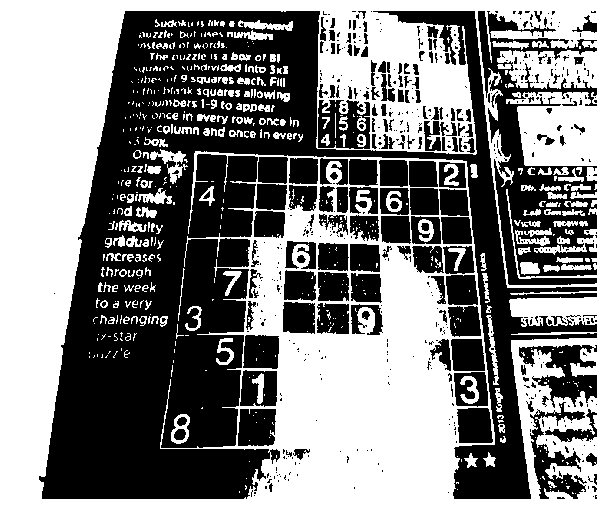

In [5]:
#adaptive threshold
#ref : http://scikit-image.org/docs/0.12.x/auto_examples/segmentation/plot_threshold_adaptive.html
from skimage.filters import threshold_otsu
binary_adaptive = threshold_otsu(blurred)
binary = blurred < binary_adaptive
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(binary , cmap="gray")
plt.show()

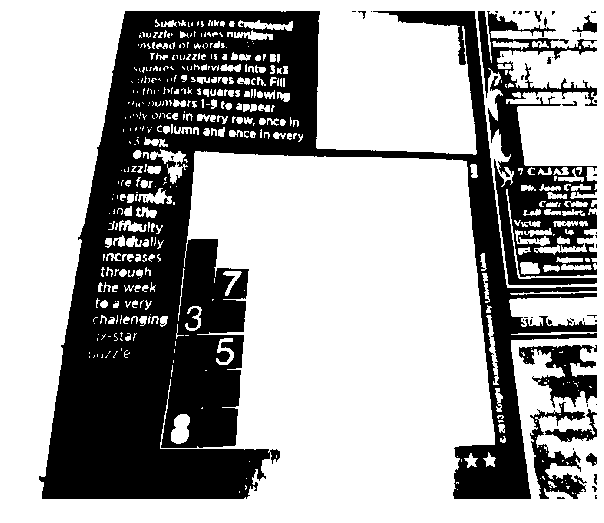

In [6]:
from scipy import ndimage as ndi

bimg = ndi.binary_fill_holes(binary)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(bimg , cmap="gray")
plt.show()

In [ ]:
from skimage.measure import find_contours
from skimage.draw import polygon_perimeter
import numpy as np

contours = find_contours(bimg, 0.8)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(bimg, interpolation='nearest', cmap=plt.cm.gray)

#find the largest blob
lengths = []
for c in contours:
    lengths.append(len(c))

def area_of_rectangle(Xmin, Xmax, Ymin, Ymax):
    return ((Ymax-Ymin)*(Xmax-Xmin))

areas_bound_by_contours = []
for index, contour in enumerate(contours):
    Xmin = np.min(contour[:,0])
    Xmax = np.max(contour[:,0])
    Ymin = np.min(contour[:,1])
    Ymax = np.max(contour[:,1])
    areas_bound_by_contours.append([index,area_of_rectangle(Xmin, Xmax, Ymin, Ymax)])

highest_area = [0,0]
for areas in areas_bound_by_contours:
    if areas[1] > highest_area[1]:
        highest_area = areas

ax.axis("off")
ax.plot(contours[highest_area[0]][:, 1], contours[highest_area[0]][:, 0], linewidth=2)  
plt.show()

In [ ]:
from skimage import transform as tf

cimp = contours[highest_area[0]]

fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(blurred, cmap="gray")
ax.plot(contours[highest_area[0]][:, 1], contours[highest_area[0]][:, 0], linewidth=2)

In [ ]:
from skimage.measure import approximate_polygon

polygon = approximate_polygon(cimp,50)

fig, ax = plt.subplots(figsize=(10,10))
ax.axis("off")
ax.imshow(blurred, cmap="gray")
ax.plot(polygon[:, 1], polygon[:, 0], linewidth=1) 

In [ ]:
import math

#ref:https://stackoverflow.com/questions/1211212/how-to-calculate-an-angle-from-three-points
def findAngle(p0,p1,p2):
    b = (p1[0]-p0[0])**2 + (p1[1]-p0[1])**2
    a = (p1[0]-p2[0])**2 + (p1[1]-p2[1])**2
    c = (p2[0]-p0[0])**2 + (p2[1]-p0[1])**2
    return math.degrees(math.acos( (a+b-c) / math.sqrt(4*a*b) ))

In [ ]:
angles_and_points = []
npoints = len(polygon)-1
for i in range(npoints):
    p1index = i
    p2index = i + 1
    p3index = i + 2
    
    if p1index == npoints-2:
        p3index = 0
        
    if p1index == npoints-1:
        p2index = 0
        p3index = 1
    
    try:
        angle = findAngle(polygon[p1index],polygon[p2index],polygon[p3index])
        if angle < 110:
            angles_and_points.append([polygon[p2index],angle])
    except:
        pass

In [ ]:
x = []
y = []
for k in angles_and_points:
    x.append(k[0][1])
    y.append(k[0][0])

In [ ]:
x,y

In [ ]:
from skimage import transform as tf

src = np.array([[0, 0], [0, 900], [900, 900], [900, 0]])
dst = np.array([[x[1],y[1]], [x[0],y[0]], [x[3],y[3]], [x[2],y[2]] ])

tform3 = tf.ProjectiveTransform()
tform3.estimate(src, dst)
warped = tf.warp(gray_img, tform3, output_shape=(900, 900))

fig, ax = plt.subplots(ncols=2,figsize=(10,20))
ax[0].imshow(gray_img, cmap="gray")
ax[0].plot(polygon[:, 1], polygon[:, 0], linewidth=1)
ax[0].plot(x, y, '.r')
ax[1].imshow(warped, cmap="gray")

In [ ]:
from skimage.measure import label, regionprops
import numpy as np
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.morphology import closing

thresh = threshold_otsu(warped)
img = closing(warped > thresh)

#add some padding.
img_c = np.ones((img.shape[0]+8,img.shape[1]+8))
img_c[4:-4,4:-4] = img


label_image = label(img_c,background=1)
image_label_overlay = label2rgb(label_image, image=img_c)

fig, ax = plt.subplots(figsize=(10, 10))

rp = regionprops(label_image)

def reject_region(w,h,img_x,img_y):
    if w/h < 0.1 or w/h > 10:
        return True

    if ((w * h) > ((img_x * img_y) / 5)) or ((w * h) < 15):
        return True

    return False

for region in rp:
    minr, minc, maxr, maxc = region.bbox
    if reject_region((maxc-minc), (maxr-minr), img_c.shape[0], img_c.shape[1]) == True:
        for coord in region.coords:
            img_c[coord[0],coord[1]] = 1

ax.imshow(img_c, cmap="gray")
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
#divide the transformed image into 9 x 9 grid.
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(10,10))
for row in range(9):
    for col in range(9):
        ax[row][col].axis("off")
        ax[row][col].imshow(warped[row*100:row*100+100,col*100:col*100+100] , cmap="gray") 

In [ ]:
#display the gradient descriptors
from skimage.feature import hog

def h_o_g(image):
    return hog(image, visualise=True)

#out, hog_image = hog(warped[0:100,400:500], visualise=True)
data = []
fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(10,10))
for row in range(9):
    for col in range(9):
        ax[row][col].axis("off")
        out, hog_image = h_o_g(warped[row*100:row*100+100,col*100:col*100+100])
        data.append(out)
        ax[row][col].imshow(hog_image, cmap="gray") 

In [ ]:
#train my classifier for digits
import os

digits_images = []
feature_list = []
targets = []
for digit in range(9):
    training_directory = 'resources/digits/'+str(digit)+'/'
    for filename in os.listdir(training_directory):
        if (filename.endswith('.png')):
            training_digit = imread(training_directory+filename)
            training_digit = rgb2grey(training_digit)#color to gray
            digits_images.append(training_digit)
            feature_list.append(h_o_g(training_digit))
            targets.append(digit)

In [ ]:
feature_list[0]

In [ ]:
from sklearn import preprocessing

hog_features = np.array(feature_list, 'float64')

In [ ]:
pp = preprocessing.StandardScaler().fit(hog_features)
hog_features = pp.transform(hog_features)

In [ ]:
from sklearn.decomposition import PCA

pc = PCA(n_components=10)
pc = pc.fit(hog_features)
minimal = pc.transform(hog_features)
print minimal.shape

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(minimal, targets, test_size = 0.2, random_state = 0)

In [ ]:
from sklearn.svm import SVC
# # Create an linear SVM object
clf = SVC()
# # Perform the training
clf.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

y_pred = clf.predict(minimal)
print(classification_report(targets,y_pred))

In [ ]:
import skimage
#check if 6 is predicted properly
six = warped[0:100,400:500]
six = skimage.transform.resize(six,(128,128))

six_binary_adaptive = threshold_local(six, block_size=99)
binary = six <= six_binary_adaptive
six = skimage.util.invert(binary)*1
plt.axis('off')
plt.imshow(six, cmap="gray")

In [ ]:
siz_feature_list = []
six_hog = h_o_g(six)
print six_hog.shape
print feature_list[0].shape
siz_feature_list.append(six_hog)
six_hog_hog_features = np.array(siz_feature_list, 'float64')
six_minimal = pc.transform(six_hog_hog_features)
y_pred = clf.predict(six_minimal)

In [ ]:
y_pred

In [ ]:
plt.imshow(six, cmap="gray")